 # A simple test of using `optuna` for hyperparameter optimization

In [1]:
import time
from types import SimpleNamespace

import pydove as dv
from tqdm.notebook import tqdm

import torch
from cpcn import LinearCPCNetwork, load_mnist, Trainer

import optuna
from optuna.trial import TrialState

 ## Defining the optimization

In [2]:
def optuna_reporter(trial: optuna.trial.Trial, ns: SimpleNamespace):
    trial.report(ns.val_loss, ns.epoch)

    # early pruning
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()


def create_cpcn(trial):
    # n_hidden = trial.suggest_int("n_hidden", 1, 3)
    n_hidden = 1
    # dims = [28 * 28]
    # for i in range(n_hidden):
    #     n_units = trial.suggest_int(f"n_units_l{i}", 3, 64)
    #     dims.append(n_units)
    # dims.append(10)
    dims = [28 * 28, 5, 10]

    z_lr = trial.suggest_float("z_lr", 1e-5, 0.2, log=True)

    # set parameters to match a simple PCN network
    g_a = 0.5 * torch.ones(len(dims) - 2)
    g_a[-1] *= 2

    g_b = 0.5 * torch.ones(len(dims) - 2)
    g_b[0] *= 2

    net = LinearCPCNetwork(
        dims,
        z_lr=z_lr,
        z_it=50,
        g_a=g_a,
        g_b=g_b,
        c_m=0,
        l_s=g_b,
        bias_a=False,
        bias_b=False,
    )

    return net


def objective(
    trial: optuna.trial.Trial, n_epochs: int, dataset: dict, device: torch.device
) -> float:
    net = create_cpcn(trial).to(device)

    optimizer_type = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    optimizer_class = getattr(torch.optim, optimizer_type)
    # optimizer_class = torch.optim.Adam
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

    rep_gamma = trial.suggest_float("rep_gamma", 1e-7, 0.2, log=True)

    trainer = Trainer(net, dataset["train"], dataset["validation"])
    trainer.set_optimizer(optimizer_class, lr=lr)
    trainer.add_scheduler(
        lambda optim: torch.optim.lr_scheduler.ExponentialLR(optim, gamma=1 - rep_gamma)
    )

    trainer.add_epoch_observer(lambda ns: optuna_reporter(trial, ns))
    results = trainer.run(n_epochs)

    return results.validation.pc_loss[-1]

In [3]:
# minimizing PC loss
t0 = time.time()

device = torch.device("cpu")

n_epochs = 50
dataset = load_mnist(n_train=2000, n_validation=1000, batch_size=100)

study = optuna.create_study(direction="minimize")
study.optimize(
    lambda trial: objective(trial, n_epochs, dataset, device),
    n_trials=200,
    timeout=1800,
    show_progress_bar=True,
)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

t1 = time.time()

[I 2022-04-22 15:01:48,449] A new study created in memory with name: no-name-31e28eb4-8f33-4bb3-a4b3-85e06b7e9b01
/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2022-04-22 15:02:06,337] Trial 0 finished with value: 0.953887140750885 and parameters: {'z_lr': 0.013077177969602663, 'optimizer': 'SGD', 'lr': 0.00048400745856066953, 'rep_gamma': 0.0029504817654824314}. Best is trial 0 with value: 0.953887140750885.
[I 2022-04-22 15:02:24,009] Trial 1 finished with value: 0.3223917245864868 and parameters: {'z_lr': 0.07137380845560223, 'optimizer': 'SGD', 'lr': 0.010389901011835529, 'rep_gamma': 6.336119533536925e-05}. Best is trial 1 with value: 0.3223917245864868.
[I 2022-04-22 15:02:41,747] Trial 2 finished with value: 0.3568132847547531 and parameters: {'z_lr': 0.18737698192393246, 'optimizer': 'RMSprop', 'lr': 0.003537522960408766, 'rep_gamma': 0.00226583103853833}. Best is trial 1 with value: 0.3223917245864868.
[I 2022-04-22 15:02:59,569] Trial 3 finished with value: 0.40440708100795747 and parameters: {'z_lr': 0.0048712290028189095, 'optimizer': 'Adam', 'lr': 0.000651145586815118, 'rep_gamma': 9.88282058664027e-06}. Best is trial 1 with v

/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:03:25,189] Trial 10 pruned. 
[I 2022-04-22 15:03:25,559] Trial 11 pruned. 
[I 2022-04-22 15:03:25,929] Trial 12 pruned. 
[I 2022-04-22 15:03:26,303] Trial 13 pruned. 
[I 2022-04-22 15:03:27,028] Trial 14 pruned. 
[I 2022-04-22 15:03:44,652] Trial 15 finished with value: 0.3630961537361145 and parameters: {'z_lr': 1.0492288357468636e-05, 'optimizer': 'SGD', 'lr': 0.0031631937642834377, 'rep_gamma': 2.191963247061381e-06}. Best is trial 1 with value: 0.3223917245864868.
[I 2022-04-22 15:03:45,031] Trial 16 pruned. 
[I 2022-04-22 15:03:45,746] Trial 17 pruned. 
[I 2022-04-22 15:03:55,400] Trial 18 pruned. 
[I 2022-04-22 15:04:07,477] Trial 19 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:04:07,854] Trial 20 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:04:08,250] Trial 21 pruned. 
[I 2022-04-22 15:04:09,373] Trial 22 pruned. 
[I 2022-04-22 15:04:10,088] Trial 23 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:04:10,457] Trial 24 pruned. 
[I 2022-04-22 15:04:10,821] Trial 25 pruned. 
[I 2022-04-22 15:04:12,222] Trial 26 pruned. 
[I 2022-04-22 15:04:12,596] Trial 27 pruned. 
[I 2022-04-22 15:04:14,331] Trial 28 pruned. 
[I 2022-04-22 15:04:14,731] Trial 29 pruned. 
[I 2022-04-22 15:04:15,120] Trial 30 pruned. 
[I 2022-04-22 15:04:15,485] Trial 31 pruned. 
[I 2022-04-22 15:04:16,228] Trial 32 pruned. 
[I 2022-04-22 15:04:16,607] Trial 33 pruned. 
[I 2022-04-22 15:04:16,968] Trial 34 pruned. 
[I 2022-04-22 15:04:17,674] Trial 35 pruned. 
[I 2022-04-22 15:04:29,484] Trial 36 pruned. 
[I 2022-04-22 15:04:47,083] Trial 37 finished with value: 0.5316573143005371 and parameters: {'z_lr': 0.10170330612213592, 'optimizer': 'RMSprop', 'lr': 0.002617968606847675, 'rep_gamma': 5.450942913990301e-05}. Best is trial 1 with value: 0.3223917245864868.


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:04:47,446] Trial 38 pruned. 
[I 2022-04-22 15:04:47,838] Trial 39 pruned. 
[I 2022-04-22 15:04:49,944] Trial 40 pruned. 
[I 2022-04-22 15:04:50,310] Trial 41 pruned. 
[I 2022-04-22 15:04:50,669] Trial 42 pruned. 
[I 2022-04-22 15:05:01,552] Trial 43 pruned. 
[I 2022-04-22 15:05:01,919] Trial 44 pruned. 
[I 2022-04-22 15:05:02,286] Trial 45 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:05:02,653] Trial 46 pruned. 
[I 2022-04-22 15:05:03,031] Trial 47 pruned. 
[I 2022-04-22 15:05:03,409] Trial 48 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:05:03,778] Trial 49 pruned. 
[I 2022-04-22 15:05:04,178] Trial 50 pruned. 
[I 2022-04-22 15:05:05,944] Trial 51 pruned. 
[I 2022-04-22 15:05:06,670] Trial 52 pruned. 
[I 2022-04-22 15:05:07,030] Trial 53 pruned. 
[I 2022-04-22 15:05:07,738] Trial 54 pruned. 
[I 2022-04-22 15:05:08,096] Trial 55 pruned. 
[I 2022-04-22 15:05:08,461] Trial 56 pruned. 
[I 2022-04-22 15:05:11,263] Trial 57 pruned. 
[I 2022-04-22 15:05:11,626] Trial 58 pruned. 
[I 2022-04-22 15:05:12,016] Trial 59 pruned. 
[I 2022-04-22 15:05:12,382] Trial 60 pruned. 
[I 2022-04-22 15:05:12,743] Trial 61 pruned. 
[I 2022-04-22 15:05:13,113] Trial 62 pruned. 
[I 2022-04-22 15:05:13,488] Trial 63 pruned. 
[I 2022-04-22 15:05:13,848] Trial 64 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:05:14,211] Trial 65 pruned. 
[I 2022-04-22 15:05:14,577] Trial 66 pruned. 
[I 2022-04-22 15:05:17,383] Trial 67 pruned. 
[I 2022-04-22 15:05:19,146] Trial 68 pruned. 
[I 2022-04-22 15:05:19,504] Trial 69 pruned. 
[I 2022-04-22 15:05:25,772] Trial 70 pruned. 
[I 2022-04-22 15:05:26,141] Trial 71 pruned. 
[I 2022-04-22 15:05:26,506] Trial 72 pruned. 
[I 2022-04-22 15:05:33,118] Trial 73 pruned. 
[I 2022-04-22 15:05:33,481] Trial 74 pruned. 
[I 2022-04-22 15:05:34,909] Trial 75 pruned. 
[I 2022-04-22 15:05:36,401] Trial 76 pruned. 
[I 2022-04-22 15:05:36,782] Trial 77 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:05:37,151] Trial 78 pruned. 
[I 2022-04-22 15:05:37,516] Trial 79 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:05:37,877] Trial 80 pruned. 
[I 2022-04-22 15:05:38,275] Trial 81 pruned. 
[I 2022-04-22 15:05:38,990] Trial 82 pruned. 
[I 2022-04-22 15:05:39,356] Trial 83 pruned. 
[I 2022-04-22 15:05:39,716] Trial 84 pruned. 
[I 2022-04-22 15:05:40,081] Trial 85 pruned. 
[I 2022-04-22 15:05:40,443] Trial 86 pruned. 
[I 2022-04-22 15:05:47,038] Trial 87 pruned. 
[I 2022-04-22 15:05:49,165] Trial 88 pruned. 
[I 2022-04-22 15:05:49,529] Trial 89 pruned. 
[I 2022-04-22 15:05:49,911] Trial 90 pruned. 
[I 2022-04-22 15:05:56,486] Trial 91 pruned. 
[I 2022-04-22 15:05:56,852] Trial 92 pruned. 
[I 2022-04-22 15:05:57,215] Trial 93 pruned. 
[I 2022-04-22 15:05:57,574] Trial 94 pruned. 
[I 2022-04-22 15:05:57,946] Trial 95 pruned. 
[I 2022-04-22 15:05:58,989] Trial 96 pruned. 
[I 2022-04-22 15:06:01,081] Trial 97 pruned. 
[I 2022-04-22 15:06:18,307] Trial 98 finished with value: 0.3288926690816879 and parameters: {'z_lr': 0.15669236230798883, 'optimizer': 'SGD', 'lr': 0.005845301548226558, '

/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:06:18,670] Trial 99 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:06:19,033] Trial 100 pruned. 
[I 2022-04-22 15:06:19,399] Trial 101 pruned. 
[I 2022-04-22 15:06:19,763] Trial 102 pruned. 
[I 2022-04-22 15:06:20,131] Trial 103 pruned. 
[I 2022-04-22 15:06:20,496] Trial 104 pruned. 
[I 2022-04-22 15:06:37,926] Trial 105 finished with value: 0.3606198340654373 and parameters: {'z_lr': 0.15845677902035626, 'optimizer': 'RMSprop', 'lr': 0.002909547814156896, 'rep_gamma': 0.00020133133512964874}. Best is trial 1 with value: 0.3223917245864868.
[I 2022-04-22 15:06:38,294] Trial 106 pruned. 
[I 2022-04-22 15:06:55,784] Trial 107 finished with value: 0.3369475305080414 and parameters: {'z_lr': 0.19058884431266893, 'optimizer': 'SGD', 'lr': 0.005456259529409034, 'rep_gamma': 0.00021507535536015104}. Best is trial 1 with value: 0.3223917245864868.
[I 2022-04-22 15:06:56,143] Trial 108 pruned. 
[I 2022-04-22 15:06:56,528] Trial 109 pruned. 
[I 2022-04-22 15:06:57,949] Trial 110 pruned. 
[I 2022-04-22 15:07:15,267] Trial 111 finished with value

/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:07:39,661] Trial 125 pruned. 
[I 2022-04-22 15:07:40,419] Trial 126 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:07:40,787] Trial 127 pruned. 
[I 2022-04-22 15:07:41,500] Trial 128 pruned. 
[I 2022-04-22 15:07:41,870] Trial 129 pruned. 
[I 2022-04-22 15:07:42,584] Trial 130 pruned. 
[I 2022-04-22 15:07:43,301] Trial 131 pruned. 
[I 2022-04-22 15:07:43,667] Trial 132 pruned. 
[I 2022-04-22 15:07:44,037] Trial 133 pruned. 
[I 2022-04-22 15:07:44,424] Trial 134 pruned. 
[I 2022-04-22 15:07:44,796] Trial 135 pruned. 
[I 2022-04-22 15:07:45,158] Trial 136 pruned. 
[I 2022-04-22 15:07:45,528] Trial 137 pruned. 
[I 2022-04-22 15:07:45,927] Trial 138 pruned. 
[I 2022-04-22 15:07:46,303] Trial 139 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:07:46,689] Trial 140 pruned. 
[I 2022-04-22 15:07:47,094] Trial 141 pruned. 
[I 2022-04-22 15:07:51,647] Trial 142 pruned. 
[I 2022-04-22 15:07:52,016] Trial 143 pruned. 
[I 2022-04-22 15:07:52,385] Trial 144 pruned. 
[I 2022-04-22 15:07:52,744] Trial 145 pruned. 
[I 2022-04-22 15:07:53,140] Trial 146 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:07:53,509] Trial 147 pruned. 
[I 2022-04-22 15:07:53,877] Trial 148 pruned. 
[I 2022-04-22 15:07:55,297] Trial 149 pruned. 
[I 2022-04-22 15:08:13,332] Trial 150 finished with value: 0.33249386548995974 and parameters: {'z_lr': 0.13826030600838995, 'optimizer': 'SGD', 'lr': 0.005337778237502806, 'rep_gamma': 0.0006180779741619133}. Best is trial 1 with value: 0.3223917245864868.
[I 2022-04-22 15:08:14,044] Trial 151 pruned. 
[I 2022-04-22 15:08:31,475] Trial 152 finished with value: 0.32115415036678313 and parameters: {'z_lr': 0.10226242501677259, 'optimizer': 'SGD', 'lr': 0.01017740793487756, 'rep_gamma': 0.0003685567491534252}. Best is trial 152 with value: 0.32115415036678313.
[I 2022-04-22 15:08:48,994] Trial 153 finished with value: 0.3206229954957962 and parameters: {'z_lr': 0.10747476864857959, 'optimizer': 'SGD', 'lr': 0.010412040114088804, 'rep_gamma': 0.0005891430841837224}. Best is trial 153 with value: 0.3206229954957962.


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:08:49,362] Trial 154 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:08:49,765] Trial 155 pruned. 
[I 2022-04-22 15:08:50,146] Trial 156 pruned. 
[I 2022-04-22 15:08:50,516] Trial 157 pruned. 
[I 2022-04-22 15:08:50,885] Trial 158 pruned. 
[I 2022-04-22 15:08:51,272] Trial 159 pruned. 
[I 2022-04-22 15:08:51,654] Trial 160 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:08:52,043] Trial 161 pruned. 
[I 2022-04-22 15:09:09,651] Trial 162 finished with value: 0.32039588689804077 and parameters: {'z_lr': 0.16517148828999317, 'optimizer': 'SGD', 'lr': 0.009227660752552786, 'rep_gamma': 0.003673672666925076}. Best is trial 162 with value: 0.32039588689804077.
[I 2022-04-22 15:09:27,049] Trial 163 finished with value: 0.3214841216802597 and parameters: {'z_lr': 0.16171175242754146, 'optimizer': 'SGD', 'lr': 0.009444984193650032, 'rep_gamma': 0.0039529487189329205}. Best is trial 162 with value: 0.32039588689804077.
[I 2022-04-22 15:09:44,506] Trial 164 finished with value: 0.3196380376815796 and parameters: {'z_lr': 0.15688900607583509, 'optimizer': 'SGD', 'lr': 0.010288099531463566, 'rep_gamma': 0.003719166244929744}. Best is trial 164 with value: 0.3196380376815796.
[I 2022-04-22 15:10:02,050] Trial 165 finished with value: 0.32747802436351775 and parameters: {'z_lr': 0.16698184001361094, 'optimizer': 'SGD', 'lr': 0.008966388838254733, 'r

/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:10:03,513] Trial 169 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:10:03,881] Trial 170 pruned. 
[I 2022-04-22 15:10:04,263] Trial 171 pruned. 
[I 2022-04-22 15:10:04,629] Trial 172 pruned. 
[I 2022-04-22 15:10:04,992] Trial 173 pruned. 
[I 2022-04-22 15:10:05,373] Trial 174 pruned. 
[I 2022-04-22 15:10:05,745] Trial 175 pruned. 
[I 2022-04-22 15:10:06,118] Trial 176 pruned. 
[I 2022-04-22 15:10:06,485] Trial 177 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:10:06,864] Trial 178 pruned. 
[I 2022-04-22 15:10:07,241] Trial 179 pruned. 
[I 2022-04-22 15:10:07,613] Trial 180 pruned. 
[I 2022-04-22 15:10:07,992] Trial 181 pruned. 
[I 2022-04-22 15:10:18,823] Trial 182 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:10:19,188] Trial 183 pruned. 
[I 2022-04-22 15:10:19,571] Trial 184 pruned. 
[I 2022-04-22 15:10:19,963] Trial 185 pruned. 
[I 2022-04-22 15:10:20,331] Trial 186 pruned. 
[I 2022-04-22 15:10:20,692] Trial 187 pruned. 
[I 2022-04-22 15:10:21,070] Trial 188 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:10:21,443] Trial 189 pruned. 
[I 2022-04-22 15:10:21,825] Trial 190 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:10:22,196] Trial 191 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:10:22,581] Trial 192 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:10:22,954] Trial 193 pruned. 
[I 2022-04-22 15:10:23,340] Trial 194 pruned. 


/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/pruners/_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2022-04-22 15:10:23,742] Trial 195 pruned. 
[I 2022-04-22 15:10:24,123] Trial 196 pruned. 
[I 2022-04-22 15:10:24,835] Trial 197 pruned. 
[I 2022-04-22 15:10:25,204] Trial 198 pruned. 
[I 2022-04-22 15:10:25,572] Trial 199 pruned. 


In [4]:
print(
    f"{len(study.trials)} trials in {t1 - t0:.1f} seconds: "
    f"{len(complete_trials)} complete, {len(pruned_trials)} pruned."
)

trial = study.best_trial
print(f"best pc_loss: {trial.value}, for params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

200 trials in 517.3 seconds: 19 complete, 181 pruned.
best pc_loss: 0.3196380376815796, for params:
    z_lr: 0.15688900607583509
    optimizer: SGD
    lr: 0.010288099531463566
    rep_gamma: 0.003719166244929744


<ipython-input-5-83c13c1a414d>:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

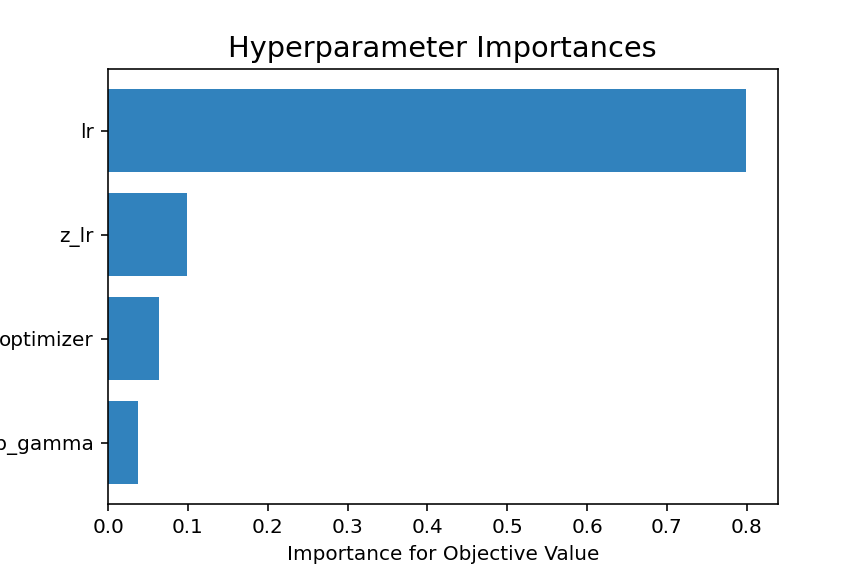

In [5]:
optuna.visualization.matplotlib.plot_param_importances(study)